# Katastrophensimulation - batch-run und Analyse
## Eigene Erweiterung des Systems [Aufgabe 6]

Als Erweiterung des Systems rund um die Simulation wählten wir eine erweiterte Auswertung des Systems.
Dafür nutzten wir die von Mesa bereitgestellten **batch-run** Möglichkeiten, mit welchen die Simulationen sehr oft und effizient ausgeführt werden konnten.
Anschließend wurden die generierten Daten mit **Pandas** in passende Formate umgewandelt und mit **Seaborn** (auf Matplotlib aufbauend) visualisiert.

In [53]:
import seaborn as sns
from schema import *
from typing import Dict, Any, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
PICKLE_FILE = "./output/batch_results.pkl"

## Aufsetzen des batch-runs

Für den batch-run können Paramter als Dictionary übergeben werden. Wenn die Parameter keine konstanten Werte, sondern Listen sind, so werden alle möglichen Kombinationen der Parameter durchlaufen. Schnell kann es dadurch zu tausenden Durchläufen kommen. 

In [54]:
# if iterables: tries all possible combinations of the parameters
parameters: Dict = {
    "width": range(8, 25, 2),
    "height": range(8, 25, 2),
    "n_survivors": range(1, 11),
    "n_save_zones": range(1, 11),
    "n_robot_agents": range(1, 7),
    "seed": 42,
}

# calculate the number of iterations for all parameters
count = 1
for key, value in parameters.items():
    # value can be a list or a range
    if isinstance(value, range):
        count *= len(list(value))
    elif isinstance(value, list):
        count *= len(value)
print("Count of combinations:", count)

Count of combinations: 48600


Mit Multiprocessing (Parameter _number\_processes_ von batch_run()) können jedoch mehrere Simulationen gleichzeitig ausgeführt werden, was die Simulationszeit deutlich reduziert. 
_Beispiel für den batch-run: 48600 Simulationen in 1:01:33 ergeben ca. 13 Simulationen pro Sekunde bei der Verwendung von zwölf logischen Prozessoren._

Besonders auffällig ist die hohe Geschwindigkeit der Simulationen bei geringen Höhen und Breiten des Labyrinths im Vergleich zu den hohen Rechendauern bei großen Labyrinthflächen. Vermutlich tritt dieser Unterschied wegen des erhöhten Rechenaufwands beim A-Stern Algorithmus für große Pfadlängen, wie es sie offensichtlich öfter bei großen Labyrinthen gibt, auf. 

Die Daten werden zur Aufbewahrung in einer pickle-Datei gespeichert und nur bei _run\_batch = True_ überschrieben.

In [55]:
# if true -> run batch, save to pickle file in output folder
# if false -> load pickle file from output folder
run_batch = False

In [56]:
if run_batch:
    batch_results = mesa.batch_run(
        model_cls=EnvironmentModel,
        parameters=parameters,
        iterations=1, # for each possible combination of parameters
        number_processes=None,
        data_collection_period=-1,
        display_progress=True,
        max_steps=1000,
    )

In [57]:
df: pd.DataFrame = None

if run_batch:
    # save results to pickle file
    df = pd.DataFrame(batch_results)
    pd.DataFrame.to_pickle(df, PICKLE_FILE)
else:
    # load the results from the pickle file
    try:
        df = pd.DataFrame(pd.read_pickle(PICKLE_FILE))
    except:
        print("batch results not available, file not found, etc.")

print(f"The results have {len(df)} rows and {len(df.columns)} columns.")
print(df.columns)
df.head(2)

The results have 170100 rows and 29 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'seed', 'Survivors', 'SaveZones',
       'MazeWidth', 'MazeHeight', 'AllSurvivorsRescued', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'AgentID', 'Tile', 'TransportedSurvivor', 'TilesMoved',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'StillRunning'],
      dtype='object')


,RunId,iteration,Step,width,height,n_survivors,n_save_zones,n_robot_agents,seed,Survivors,...,TotalTilesMoved,TotalSurvivorsPickedUp,TotalSurvivorsPlacedDown,AgentID,Tile,TransportedSurvivor,TilesMoved,SurvivorsPickedUp,SurvivorsPlacedDown,StillRunning
0,3,0,4,8,8,1,1,4,42,[<schema.Survivor object at 0x000001FC256D2E70>],...,12,4,0,1,<schema.Tile object at 0x000001FC8F1DACF0>,None,12,1,1,True
1,3,0,4,8,8,1,1,4,42,[<schema.Survivor object at 0x000001FC256D2E70>],...,12,4,0,2,<schema.Tile object at 0x000001FC8F1DAD50>,<schema.Survivor object at 0x000001FC93EA7230>,0,1,0,False


## Data transformation

Die Daten werden mit Pandas in einem DataFrame für die Verwendung angepasst.

In [58]:
df.drop(
    [
        "seed", 
        "Survivors", 
        "MazeWidth", 
        "MazeHeight", 
        "AllSurvivorsRescued", 
        "Tile", 
        "StillRunning",
        "AgentID",
        "TransportedSurvivor",
        "TilesMoved"
    ],
    axis=1,
    inplace=True,
)
print(f"The results have reduced {len(df.columns)} columns.")
print(df.columns)

# get the ratio of TilesMoved per SurvivorCount as the column "TilesMovedPerSurvivor"
df["TilesMovedPerSurvivor"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_survivors"] if x["n_survivors"] > 0 else 0, axis=1
)

# get the ratio of TilesMoved per SaveZoneCount as the column "TilesMovedPerSaveZone"
df["TilesMovedPerSaveZone"] = df.apply(
    lambda x: x["TotalTilesMoved"] / x["n_save_zones"] if x["n_save_zones"] > 0 else 0,
    axis=1,
)

# get pathlengths parameters. only works if data_collection_period is set to 1
df["PathlengthMin"] = df.apply(
    lambda x: EnvironmentModel.get_min_pathlength(
        x["InitialPathlengths"]
    ),
    axis=1,
)
df["PathlengthMax"] = df.apply(
    lambda x: EnvironmentModel.get_max_pathlength(x["InitialPathlengths"]),
    axis=1,
)
df["PathlengthMean"] = df.apply(
    lambda x: EnvironmentModel.get_mean_pathlength(x["InitialPathlengths"]),
    axis=1,
)

# grouping of survivor / save zone / robot counts
df["SurvivorCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_survivors"] < 5 else "High (>=5)", axis=1
)
df["SaveZoneCountGroup"] = df.apply(
    lambda x: "Low (<5)" if x["n_save_zones"] < 5 else "High (>=5)", axis=1
)
df["RobotCountGroup"] = df.apply(
    lambda x: "Low (<4)" if x["n_robot_agents"] < 3 else "High (>=4)", axis=1
)

# height * width
df["MazeArea"] = df.apply(
    lambda x: x["width"] * x["height"], axis=1
)

The results have reduced 19 columns.
Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'SaveZones', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown'],
      dtype='object')


## Data analysis
### Korrelationsmatrix

Mit einem [Seaborn-Beispiel](https://seaborn.pydata.org/archive/0.11/examples/many_pairwise_correlations.html) wird die Korrelationsmatrix der gesammelten Daten visualisiert.


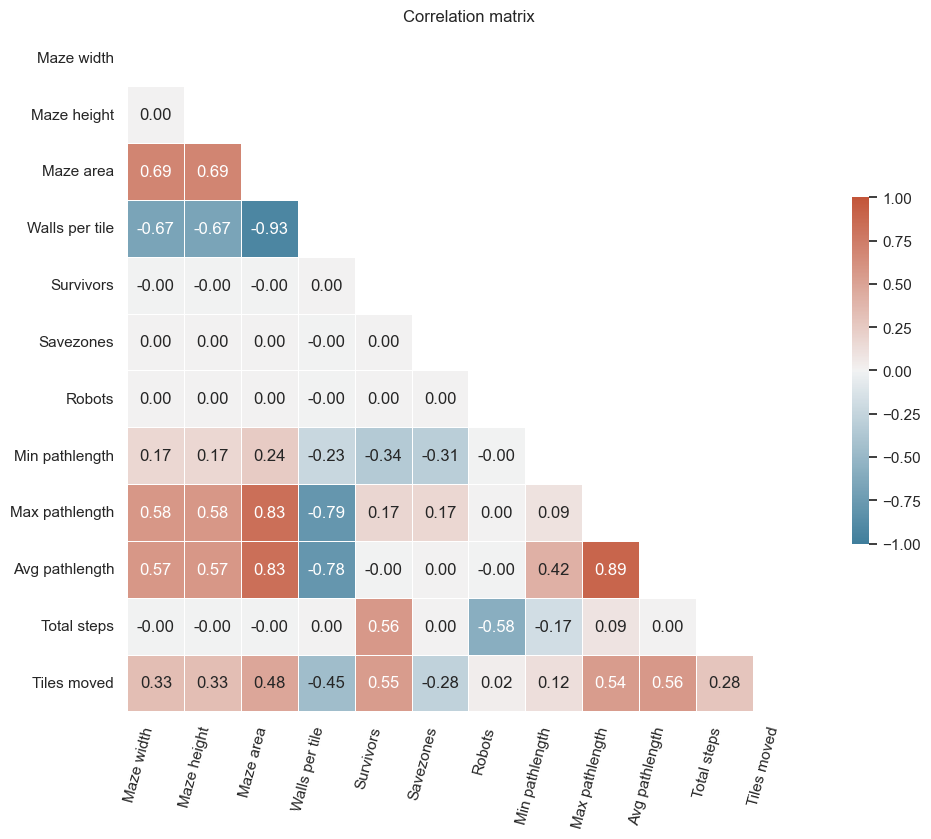

In [59]:
# choose some columns
df_corr = df.reset_index()
df_corr = df_corr[
    [
        "width",
        "height",
        "MazeArea",
        "MeanWallDensity",
        "n_survivors",
        "n_save_zones",
        "n_robot_agents",
        "PathlengthMin",
        "PathlengthMax",
        "PathlengthMean",
        "Step",
        "TotalTilesMoved",
    ]
]
df_corr.rename(
    columns={
        "width": "Maze width",
        "height": "Maze height",
        "MazeArea": "Maze area",
        "MeanWallDensity": "Walls per tile",
        "n_survivors": "Survivors",
        "n_save_zones": "Savezones",
        "n_robot_agents": "Robots",
        "PathlengthMin": "Min pathlength",
        "PathlengthMax": "Max pathlength",
        "PathlengthMean": "Avg pathlength",
        "Step": "Total steps",
        "TotalTilesMoved": "Tiles moved",
    },
    inplace=True,
)

corr = df_corr.corr()

# Correlation matrix with mask for upper triangle
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
)
plt.title("Correlation matrix")
plt.xticks(rotation=75, ha="right")
plt.savefig("./output/correlation_heatmap.png", dpi=300, bbox_inches="tight");

In [60]:
# TODO: setze Wert für Korrelation zwischen "walls per tile" und "max/avg pathlength" nach neuer Simulation neu.

Aus der **Korrelationsmatrix** werden folgende Zusammenhänge ersichtlich:

### Simulationsschritte
Offensichtlich hängt die Anzahl der **Simulationsschritte** "Total steps" nicht von der Höhe, Breite oder der Anzahl der SaveZones ab, sondern nur von der Anzahl der zu rettenden Überlebenden und der bereitgestellten Roboter. Wäre die Bewegungsreichweite der Roboter pro Simulationsschritt begrenzt, so würde hier eine von den Paramtern dargestellt werden können.

### Wanddichte x Pfadlänge

Interessant ist der Zusammenhang zwischen der Dichte als **Wände pro Feld** des Labyrinths "Walls per tile" mit der maximalen, bzw. durchschnittlichen, **Pfadlänge** "Max/Avg pathlength" mit einem Wert von ca. 0,8 [TODO].
Visualisiert man den Zusammenhang als Lineplot (siehe unten), so zeigt sich, dass trotz nur minimaler Änderungen der Dichte der Wände pro Feld, die Pfadlängen sehr stark variieren.
Deskriptiv bedeutet das, dass mit steigender Anzahl an (relevanten) Wänden pro Feld, die durchschnittliche und maximale Pfadlänge ansteigt. 

In [61]:
# TODO
# >erstelle evtl. eine Grafik für die Vermutung in der anderen file:
# > Uns fiel in den Simulationen auf, dass isolierte SaveZones (*) oft eine Großzahl
# an Überlebenden beherbergen. Mit genug Simulationsdaten wäre diese Annahme interessant,
# zu überprüfen. Dafür müssten die Pfadlängen zwischen den SaveZones selbst und die am Ende 
# beherbergten Überlebenden gesammelt und analysiert werden. 

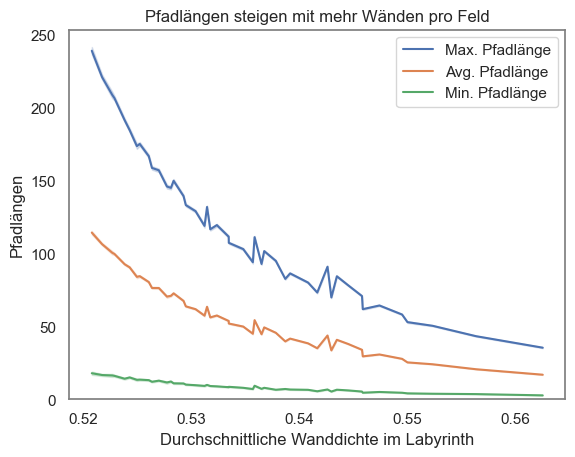

In [ ]:
sns.lineplot(data=df, x="MeanWallDensity", y="PathlengthMax", label="Max. Pfadlänge")
sns.lineplot(data=df, x="MeanWallDensity", y="PathlengthMean", label="Avg. Pfadlänge")
sns.lineplot(data=df, x="MeanWallDensity", y="PathlengthMin", label="Min. Pfadlänge")

plt.title("Pfadlängen steigen mit mehr Wänden pro Feld")
plt.xlabel("Durchschnittliche Wanddichte im Labyrinth")
plt.ylabel("Pfadlängen")

plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/wall_density_pathlengths.png", dpi=300, bbox_inches="tight")

Normale Passagen (z.B. ein Weg von links nach rechts) haben zwei Wände und zwei offene Wege im Labyrinth. Sackgassen haben drei Wände, von einer Seite kann hergekommen werden. Ausgänge müssen mindestens einen Ort der Herkunft haben, sowie am Rand eine Öffnung, bzw. an einer Ecke zwei Öffnungen. Die Öffnungen zum Rand sind jedoch nicht relevant, da sie nicht zu anderen Feldern zugewandt sind; sie sollten daher nicht mitgezählt werden.
Daraus lässt sich ableiten: Generell sollte die durchschnittliche Anzahl der Wände in einem Labyrinth ohne Ausgänge und ohne Sackgassen stets zwei sein, da das gesamte Labyrinth eine einzige Passage ohne Abzweigungen und Stops ist. 

Fügt man Sackgassen, die durch den iterativen Ansatz des random DFS typischerweise erzeugt werden, hinzu, so steigt die Anzahl der Wände bei diesen Positionen auf drei - die Dichte der Wände steigt somit. Perfekte Labyrinthe mit zwei Ausgängen (als Eingang und Ausgang) und ohne Sackgassen haben eine maximale Pfadlänge zwischen zwei Punkten von der Anzahl der insgesamten Felder im Labyrinth, da es nur einen Pfad vom Eingang (Punkt 1) zum Ausgang (Punkt 2) gibt.
Sackgassen führen im Allgemeinen zu einer Verschachtelung des Labyrinths, reduzieren jedoch im Vergleich zu dem Labyrinth mit einer einzigen Passage die effektiv nötige Pfadlänge. Das resultiert aus der Tatsache, dass manche Felder, die der einzigen langen Passage zwischen Eingang und Ausgang angehören könnten, stattdessen als Sackgasse verwendet werden. Wird der Weg zwischen zwei Punkten (z.B. Eingang und Ausgang) nun betrachtet, so können die Sackgassen dazwischen für die Pfadlänge ignoriert werden.

Aus dieser Überlegung kann gefolgert werden, dass die durchschnittliche und maximale Pfadlänge im Labyrinth mit steigender Anzahl der Wände pro Feld unter Berücksichtigung der Sackgassen ansteigt.
Die Korrelation aus der Correlation Matrix bezeugt dieses Verhalten.

### Anzahl der bewegten Felder
#### Bewegte Felder x Anzahl Überlebende

Die Anzahl der bewegten Felder "Tiles moved" steigt off... TODO

Aus der vorherigen Analyse der Pfadlängen kann gefolgert werden, dass die Anzahl der bewegten Felder "Tiles moved

Offensichtlich steigt die Anzahl der bewegten Felder mit der Anzahl der Überlebenden an.
Leicht auffällig ist dabei die minimale Degressivität des Graphen bei einer Anzahl der Überlebenden von über 4. 

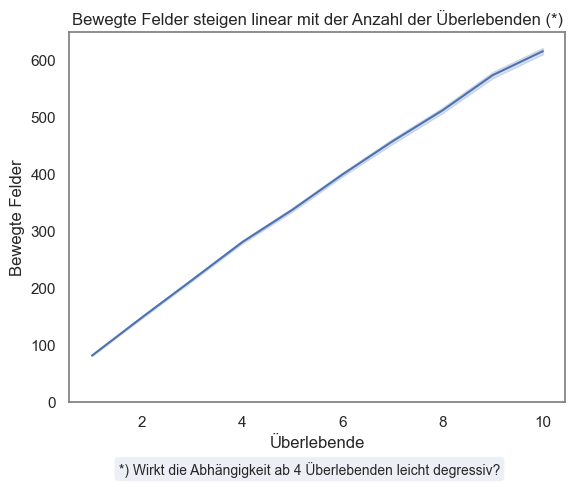

In [63]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved")
plt.title("Bewegte Felder steigen linear mit der Anzahl der Überlebenden (*)")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")

plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.figtext(
    0.5,
    -0.04,
    "*) Wirkt die Abhängigkeit ab 4 Überlebenden leicht degressiv?",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

plt.savefig("./output/tiles_moved_per_survivor.png", dpi=300, bbox_inches="tight")

Eine Vermutung für den leichten Abfall der linearen Abhängigkeit der bewegten Felder von der Anzahl der Überlebenden wäre, dass die Roboter bei mehr Überlebenden generell kürzere Pfade finden können, da es auch mehr Auswahlmöglichkeiten gibt.

Bestätigen könnte man diese These, wenn eine erhöhte Anzahl Überlebenden pro bewegten Feldern einen reduzierenden Effekt auf die bewegten Felder und somit die Pfadlängen haben sollten.

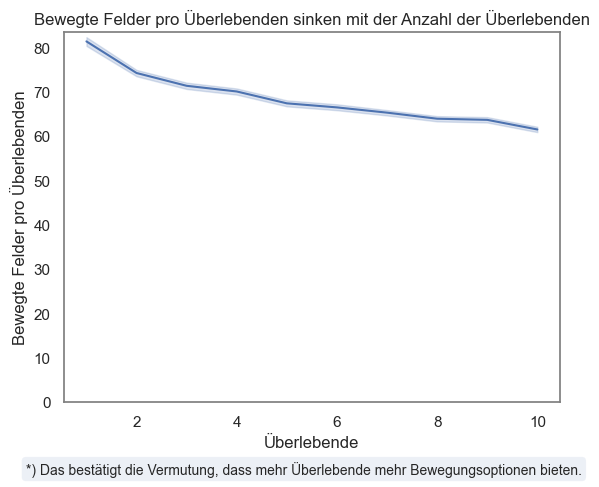

In [64]:
sns.lineplot(data=df, x="n_survivors", y="TilesMovedPerSurvivor")
plt.title("Bewegte Felder pro Überlebenden sinken mit der Anzahl der Überlebenden")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder pro Überlebenden")

plt.ylim(bottom=0)
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.figtext(
    0.5,
    -0.04,
    "*) Das bestätigt die Vermutung, dass mehr Überlebende mehr Bewegungsoptionen bieten.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

plt.savefig("./output/tiles_moved_per_survivor_on_survivor.png", dpi=300, bbox_inches="tight")

Es wird Erkenntlich, dass mehr Überlebende generell zu weniger bewegten Feldern pro Überlebenden führen.
Das lässt sich auch mit der Anzahl der Savezones beweisen, die die Pfadlängen zwischen Roboter (startend von den Savezones) und den Überlebenden mindern.

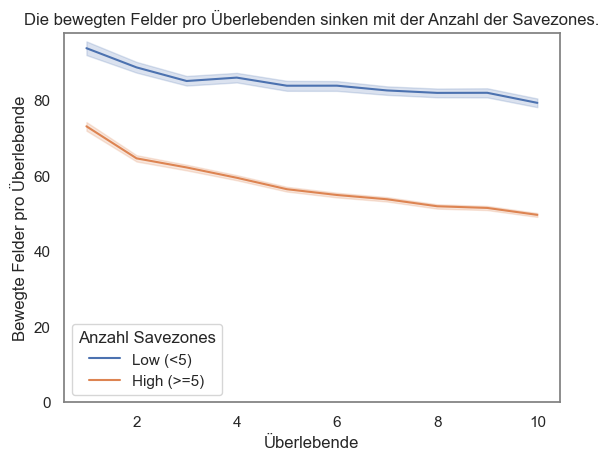

In [65]:
sns.lineplot(data=df, x="n_survivors", y="TilesMovedPerSurvivor", hue="SaveZoneCountGroup")
# sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="SaveZoneCountGroup")
plt.title("Die bewegten Felder pro Überlebenden sinken mit der Anzahl der Savezones.")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder pro Überlebende")
plt.ylim(bottom=0)
plt.legend(title="Anzahl Savezones")
for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig("./output/tiles_moved_per_survivor_on_savezones.png", dpi=300, bbox_inches="tight")

Aus der Grafik wird ersichtlich, dass mehr Savezones (>=5) zu einer Reduzierung der bewegten Felder pro Überlebenden führen.

Fraglich dabei ist, ob die Anzahl der Roboter auch einen positiven Einfluss auf die Pfadlängen hat. Die Vermutung wäre, dass sich Roboter wegen des gegenseitigen Wegnehmens des nähesten Überlebenden im Allgemeinen mehr bewegen müssen, schließlich steigen die Pfadlängen, wenn eine weniger optimale Lösung mit dem A-Stern Algorithmus gefunden wird.

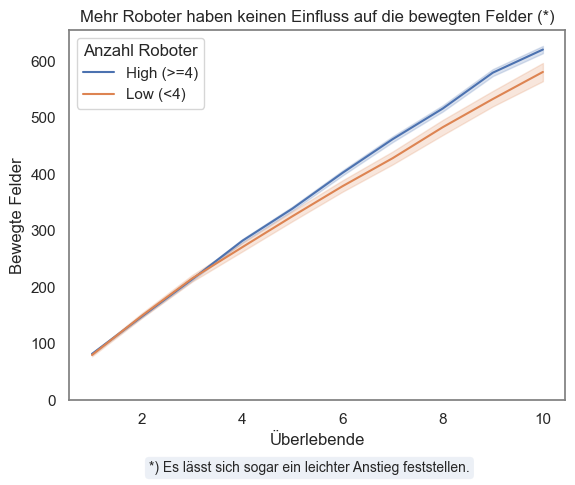

In [66]:
sns.lineplot(data=df, x="n_survivors", y="TotalTilesMoved", hue="RobotCountGroup")
plt.title("Mehr Roboter haben keinen Einfluss auf die bewegten Felder (*)")
plt.xlabel("Überlebende")
plt.ylabel("Bewegte Felder")
plt.ylim(bottom=0)

plt.legend(title="Anzahl Roboter")
plt.figtext(
    0.5,
    -0.04,
    "*) Es lässt sich sogar ein leichter Anstieg feststellen.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/tiles_moved_per_survivor_grouped_robots.png", dpi=300, bbox_inches="tight"
)

Offensichtlich läuft die Simulation mit weniger Simulationsschritten ab, da mehr Roboter zur Verfügung stehen.

Die insgesamte Anzahl der bewegten Felder als Summe der zurückgelegten Felder pro Roboter steigt jedoch ab einer Anzahl von 4 Robotern leicht an.
Das bestätigt die Vermutung, dass die Roboter sich gegenseitig die optimalen Überlebenden und somit kürzesten Pfade wegnehmen. Bei einer Realwelt-Implementierung sollte deshalb auf geeigntete Kommunikation und Koordination zwischen den Robotern geachtet werden, um die Suchzeit zu reduzieren.

Mehr Roboter haben somit keinen positiven Einfluss auf die Pfadlängen, sondern erhöhen diese sogar wahrnehmbar.

### Pathlength x SaveZones

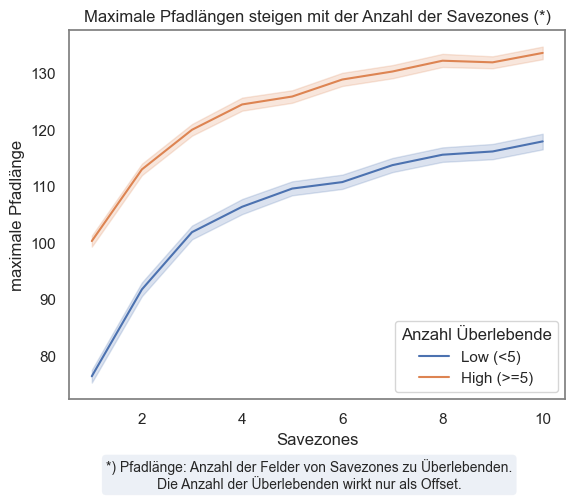

In [83]:
sns.lineplot(data=df, x="n_save_zones", y="PathlengthMax", hue="SurvivorCountGroup")

plt.title("Maximale Pfadlängen steigen mit der Anzahl der Savezones (*)")
plt.xlabel("Savezones")
plt.ylabel("maximale Pfadlänge")

plt.legend(title="Anzahl Überlebende")
plt.figtext(
    0.5,
    -0.07,
    "*) Pfadlänge: Anzahl der Felder von Savezones zu Überlebenden.\n" + 
    "Die Anzahl der Überlebenden wirkt nur als Offset.",
    wrap=True,
    horizontalalignment="center",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1),
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/savezones_maxpathlengths_grouped_survivors.png", dpi=300, bbox_inches="tight"
)

#### MazeArea (width *height) x MovedTiles

In [68]:
df.columns

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n_survivors',
       'n_save_zones', 'n_robot_agents', 'SaveZones', 'InitialPathlengths',
       'MeanWallDensity', 'HorizontalSymmetry', 'VeticalSymmetry', 'ExitCount',
       'TotalTilesMoved', 'TotalSurvivorsPickedUp', 'TotalSurvivorsPlacedDown',
       'SurvivorsPickedUp', 'SurvivorsPlacedDown', 'TilesMovedPerSurvivor',
       'TilesMovedPerSaveZone', 'PathlengthMin', 'PathlengthMax',
       'PathlengthMean', 'SurvivorCountGroup', 'SaveZoneCountGroup',
       'RobotCountGroup', 'MazeArea'],
      dtype='object')

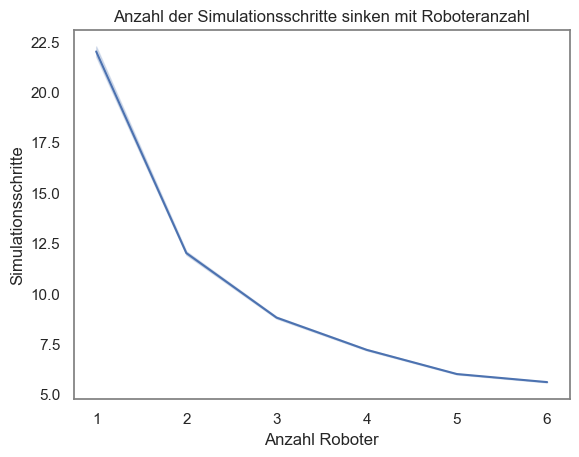

In [69]:
# 3 plots with same y axis
sns.lineplot(data=df, x="n_robot_agents", y="Step")


plt.title("Anzahl der Simulationsschritte sinken mit Roboteranzahl") # TODO: linear???
plt.xlabel("Anzahl Roboter")
plt.ylabel("Simulationsschritte")
plt.xticks(
    range(
        df["n_robot_agents"].min(),
        df["n_robot_agents"].max() + 1,
    )
)

for side in ["top", "bottom", "left", "right"]:
    plt.gca().spines[side].set_color("gray")

plt.savefig(
    "./output/simulationsteps_per_agent.png",
    dpi=300,
    bbox_inches="tight",
)